---
title: "Example Notebooks of ODE Solver" \
author: "Naoya Ozaki" \
date: "28 December 2022" \
output: "ode_example"

---

# 1. はじめに

Julia言語を用いて，常微分方程式の数値解法を行う際に，最も広く利用されているライブラリは[`DifferentialEquations.jl`](https://github.com/SciML/DifferentialEquations.jl)である．その他にも[`OrdinaryDiffEq.jl`](https://github.com/SciML/OrdinaryDiffEq.jl)，[`ODE.jl`](https://github.com/SciML/ODE.jl)，[`Sundials.jl`](https://github.com/SciML/Sundials.jl)等のライブラリがある．これらのライブラリは全てSciML下で管理されているものである．最初の３つはMITライセンス，`Sundials.jl`もBSD 2-Clause "Simplified"ライセンスなので，かなり緩く使えそうである．本ノートブックでは，宇宙軌道力学分野でよく登場する円制限三体問題を題材にして，これらの常微分方程式ライブラリの比較を行う．なお，CRTBPに関する詳しい説明は，ここでは割愛する．Juliaでの軌道の描画には，[`Makie.jl`](https://docs.makie.org/stable/)を用いる．描画ライブラリで何を使うかは個人の好みの問題になるが，`Makie.jl`は，[`Plots.jl`](https://docs.juliaplots.org/stable/)のように扱いやすく，[`PlotlyJS.jl`](https://github.com/JuliaPlots/PlotlyJS.jl)のようにインタラクティブに動かせ，かつ，美しい描画ができるので，個人的なお気に入りである．

# 2. 円制限三体問題の運動方程式
お互いに万有引力が作用する３つの天体がどのような運動をするのかを問う問題を**三体問題**（Three-Body Problem)と呼ぶ．三体問題は，その軌道を与える一般解が求積法では求まらない問題として知られており（＝要は，ある時刻に対する位置・速度を解析的な式で計算できない），宇宙軌道力学の分野でも数値解法が用いられる．三体問題の中でも，第三天体が及ぼす万有引力を無視した問題を**制限三体問題**(Restricted Three-Body Problem)と呼び，更に，第一天体と第二天体がその共通重心の周りを円軌道で周回する問題を**円制限三体問題** (Circular Restricted Three-Body Problem; CRTBP)と呼ぶ．宇宙軌道力学分野でよく対象となる「太陽＝地球＝宇宙機の三体問題」や「地球＝月＝宇宙機の三体問題」は，CRTBPで非常によく近似できる．よく近似できるとは言え，あくまで近似であり，実際の宇宙機運用を考えると無視できない誤差が生じる．それにも関わらず，なぜ軌道力学の専門家が，CRTBPを使いたがるかと言うと，CRTBPの運動方程式は，**自励系**（＝独立変数を陽に含まない常微分方程式）となっているからである．自励系で表されることで，力学系理論等の解析的なテクニックを利用することが可能となる．

CRTBPでは，第一天体と第二天体の共通重心を中心として，第一天体から見た第二天体の位置ベクトル方向を$x$軸，第一天体に対する第二天体の角運動量ベクトル方向を$z$軸，右手系をなすように$y$軸（＝第二天体の速度ベクトル方向）を取った座標系において，運動方程式を記述することが多い．詳しい導出は書略するが，宇宙機の位置ベクトルを$\boldsymbol{r}$，速度ベクトルを$\boldsymbol{v}$，運動方程式を規定するパラメータを$\mu=\frac{m_2}{m_1+m_2}$としたとき，CRTBPにおける宇宙機の運動方程式は，以下のような式で計算できる
$$
\left\{
\begin{align*}
\dot{\bm{r}} &= \bm{v}\\
\dot{\bm{v}} &= -\frac{1-\mu}{\|\bm{r}_1\|^3}\bm{r}_1 -\frac{\mu}{\|\bm{r}_2\|^3}\bm{r}_2 + H_{\textrm{coli}}\bm{v} + H_{\textrm{cf}}\bm{r}
\end{align*}
\right.
$$

ただし，
$$
\begin{align*}
\bm{r}_1 &= \begin{bmatrix}x+\mu & y & z\end{bmatrix}^{\top}\\
\bm{r}_2 &= \begin{bmatrix}x-(1-\mu) & y & z\end{bmatrix}^{\top}\\
H_{\textrm{coli}} &= \begin{bmatrix}
0 & 2 & 0\\
-2 & 0 & 0\\
0 & 0 & 0
\end{bmatrix}\\
H_{\textrm{cf}} &= \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 0
\end{bmatrix}
\end{align*}
$$
である．$m_1$と$m_2$は，それぞれ第一天体と第二天体の質量を表すが，太陽＝地球系のCRTBPでは$\mu=3.036\times 10^{-6}$，地球＝月系のCRTBPでは$\mu=0.01215058426994$である．

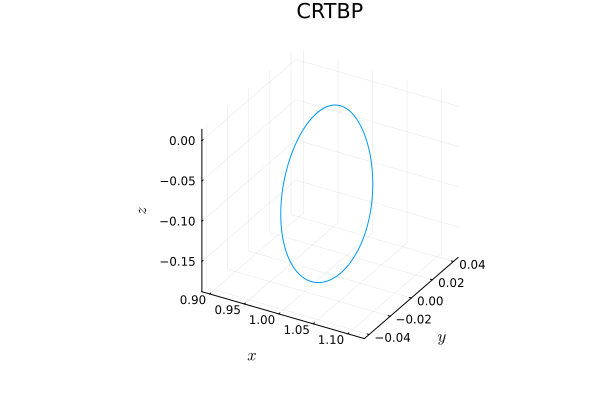

In [10]:
using ParameterizedFunctions, DifferentialEquations
using LinearAlgebra
using Plots

# 常微分方程式の定義
function crtbp!(dx,x,μ,t)
    # Preparation
    r1 = x[1:3] + [μ,0,0]
    r2 = x[1:3] - [1-μ,0,0]
    h_cori = [
         0  2  0;
        -2  0  0;
         0  0  0
    ]
    h_cf =[
        1  0  0;
        0  1  0;
        0  0  0
    ]
    # dx/dt
    dx[1:3] = x[4:6]
    dx[4:6] = -(1-μ)*r1/(norm(r1)^3) - μ*r2/(norm(r2)^3) + h_cori*x[4:6] + h_cf*x[1:3]
end

# 問題定義
# x0 = [0.995707444733282, -0.007199559925458,  0.00443836532133, 0.005316062984565,  0.006000425296496,  0.012765946563249]
x0 = [0.987384153663276, 0.0, 0.008372273063008, 0.0, 1.67419265037912, 0.0]
tspan = (0.0, 2*pi)
# prob = ODEProblem(crtbp!, x0, tspan, 3.036e-6)
prob = ODEProblem(crtbp!, x0, tspan, 0.01215058426994)

# 計算
sol = solve(prob, TsitPap8(), reltol=1e-8, abstol=1e-8)

plot(sol, vars=(1, 2, 3), title="CRTBP",
    xlabel=L"x", ylabel=L"y", zlabel=L"z", label="")

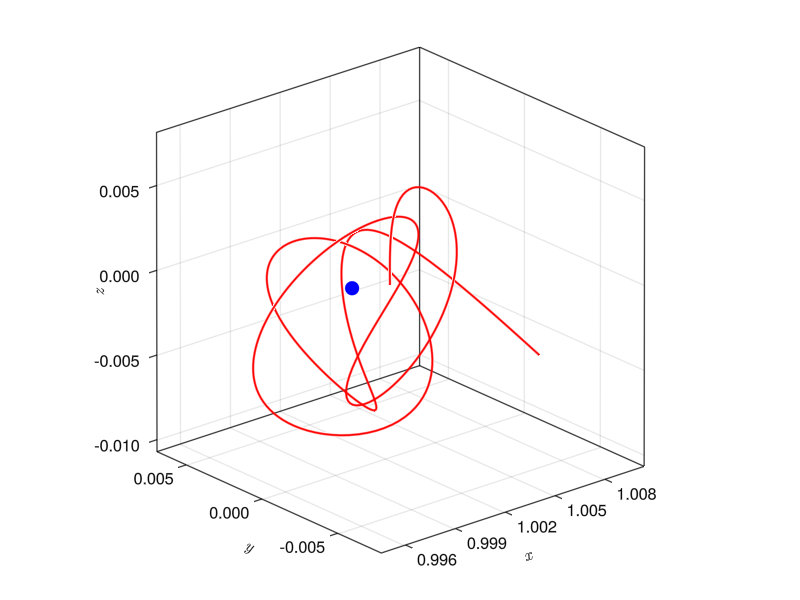

In [8]:
using ParameterizedFunctions, DifferentialEquations
using LinearAlgebra
using GLMakie
GLMakie.activate!()
Makie.inline!(true)

# 常微分方程式の定義
function crtbp!(dx,x,μ,t)
    # Preparation
    r1 = x[1:3] + [μ,0,0]
    r2 = x[1:3] - [1-μ,0,0]
    h_cori = [
         0  2  0;
        -2  0  0;
         0  0  0
    ]
    h_cf =[
        1  0  0;
        0  1  0;
        0  0  0
    ]
    # dx/dt
    dx[1:3] = x[4:6]
    dx[4:6] = -(1-μ)*r1/(norm(r1)^3) - μ*r2/(norm(r2)^3) + h_cori*x[4:6] + h_cf*x[1:3]
end

# 問題定義
x0 = [0.995707444733282, -0.007199559925458,  0.00443836532133, 0.005316062984565,  0.006000425296496,  0.012765946563249]
tspan = (0.0, 2*pi)
prob = ODEProblem(crtbp!, x0, tspan, 3.036e-6)

# 計算
sol = solve(prob, Tsit5(), reltol=1e-10, abstol=1e-10)

# 描画
fig = Figure()
ax = Axis3(fig[1, 1]; aspect=(1, 1, 1), perspectiveness=0.0, xlabel = L"x", ylabel = L"y", zlabel=L"z")
scatterlines!(ax, 1, 0, 0; markersize=20, color=:blue)
lines!(ax, sol[1, :], sol[2, :], sol[3, :], linewidth=2, color=:red)
fig

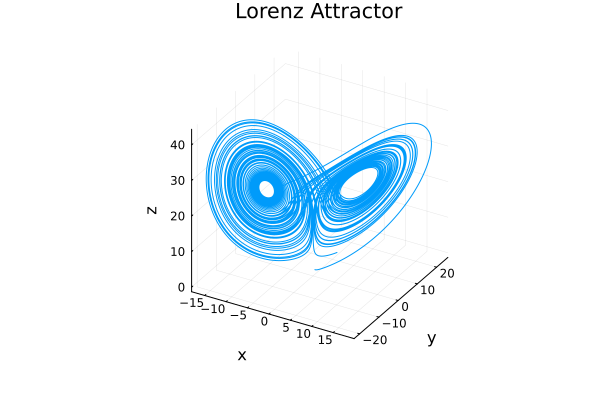

In [3]:
using Sundials
using Plots

function lorenz(du, u, p, t)
    du[1] = 10.0(u[2] - u[1])
    du[2] = u[1] * (25.0 - u[3]) - u[2]
    du[3] = u[1] * u[2] - (7 / 3) * u[3]
end
u0 = [0.0; 1.01; 0.0]
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz, u0, tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

plot(sol, vars=(1, 2, 3), title="Lorenz Attractor",
    xlabel="x", ylabel="y", zlabel="z", label="")